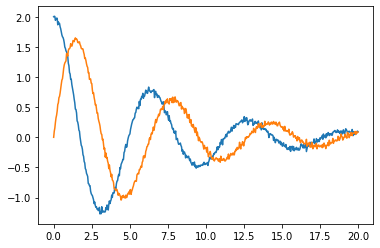

In [3]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy import integrate
import control as ctrl


def vdp1(t, x):
    return np.array([-x[1], - .3*x[1] + x[0]])

res=500
seq_len=20
t0, t1 = 0, 20                # start and end
t = np.linspace(t0, t1, res+seq_len)  # the points of evaluation of solution
x0 = [2, 0]                   # initial value
x = np.zeros((len(t), len(x0)))   # arrax for solution
x[0, :] = x0
r = integrate.ode(vdp1).set_integrator("dopri5")  # choice of method
r.set_initial_value(x0, t0)   # initial values
for i in range(1, t.size):
    x[i, :] = r.integrate(t[i])+np.random.normal(0,0.03,(2,)) # get one more value, add it to the arrax
    if not r.successful():
        raise RuntimeError("Could not integrate")
plt.plot(t, x)
plt.show()

def createInputs(x,res,seq_len):
    data_list=[]
#     target_list=[]
    for i in range(res-1):
        data_list.append([x[i:seq_len+i,:],x[seq_len+i+1,:]])
    return data_list


In [228]:
    
    

# ================================

class RNN:
  # A many-to-one Vanilla Recurrent Neural Network.
    def __init__(self, input_size, output_size, hidden_size=64):
        # Weights
        self.Whh = random.randn(hidden_size, hidden_size) / 1000
        self.Wxh = random.randn(hidden_size, input_size) / 1000
        self.Why = random.randn(output_size, hidden_size) / 1000

        # Biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
    
        h = np.zeros((self.Whh.shape[0], 1))

        self.last_inputs = inputs
        self.last_hs = { 0: h }

        # Perform each step of the RNN
        for i, xin in enumerate(inputs):
            xin=xin[...,np.newaxis]
            h = (self.Wxh @ xin + np.tanh(self.Whh @ h) + self.bh)
            self.last_hs[i + 1] = h

        # Compute the output
        y = self.Why @ h + self.by

        return y, h

    def backprop(self, d_y,epoch,g0, learn_rate=2e-3):
        n = len(self.last_inputs)

        # Calculate dL/dWhy and dL/dby.
        d_Why = d_y @ self.last_hs[n].T
        d_by = d_y

        # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)

        # Calculate dL/dh for the last h.
        # dL/dh = dL/dy * dy/dh
        d_h = self.Why.T @ d_y

        # Backpropagate through time.
        for t in reversed(range(n)):
            # An intermediate value: dL/dh * (1 - h^2)
            temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)
#             temp = d_h
            # dL/db = dL/dh * (1 - h^2)
            d_bh += d_h
            # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
            d_Whh += d_h @ np.tanh(self.last_hs[t].T)

            # dL/dWxh = dL/dh * (1 - h^2) * x
            last_x=self.last_inputs[t]
            last_x=last_x[...,np.newaxis]
            d_Wxh += d_h @ last_x.T

            # Next dL/dh = dL/dh * (1 - h^2) * Whh
            d_h = self.Whh @ temp

        # Clip to prevent exploding gradients.
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -1, 1, out=d)

        # Update weights and biases using gradient descent.
        # adding the regulization terms -----------------------------------------
        dA,dB,dC=self.Rbstdiff()
#         gamma=g0
#         gamma=g0/np.log(epoch/10+2)
        gamma=g0/((epoch/20)+1)
        learn_rate2=learn_rate*gamma
#         learn_rate=learn_rate*gamma
        self.Whh -= learn_rate * d_Whh+learn_rate2 *dA
        self.Wxh -= learn_rate * d_Wxh+learn_rate2 *dB
        self.Why -= learn_rate * d_Why+learn_rate2 *dC
        self.bh -= learn_rate * d_bh
        self.by -= learn_rate * d_by
    def Weights(self):
        return self.Whh,self.Wxh,self.Why,self.bh,self.by
    
    def Rbstdiff(self):
        A,B,C,b,c=self.Weights()
        At=np.transpose(A)
        Q=np.transpose(C)@C
        Bt=np.transpose(B)
        P=ctrl.dlyap(A,Q)
        I=np.identity(len(A))
        dB=2*P@B
        dC=-2*C@B@Bt@ np.linalg.pinv(I-At@A)
        dA=2*B@Bt@P@A @np.linalg.pinv(I-At@A)
        return dA,dB,dC

    def Prediction(self,x,sig,res,seq_len):
        y_pre=np.zeros([res-1,2])
        i=0
        x_n=x+np.random.normal(0,sig,x.shape)
        X=createInputs(x_n,res,seq_len)
        for xd in X:
            inputs = xd[0]
            target = xd[1].reshape(-1,1)
            out, _ = rnn.forward(inputs)
            y_pre[i]=out.reshape(-1,2)
            i+=1
        return y_pre

    def processData(self,x, backprop=True,batch_size=20,res=500,seq_len=20,g0=.1):
        X_train=createInputs(x,res,seq_len)
        loss = 0
        d_L_d_y=np.zeros([2,1])
        random.shuffle(X_train)
        for xd in X_train[0:batch_size]:
            inputs = xd[0]
            target = xd[1].reshape(-1,1)

            out, _ = self.forward(inputs)
            diff=(out - target)
            loss += (diff**2).mean(axis=0)

            if backprop:
                d_L_d_y += 2*(diff)
                self.backprop(d_L_d_y,epoch+1,g0)
        return loss/batch_size
    def Perf_bound(self):
        A,B,C,b,c=self.Weights()
        At=np.transpose(A)
        Q=np.transpose(C)@C
        Bt=np.transpose(B)
        P=ctrl.dlyap(A,Q)
        return np.trace(Bt@P@B)


# ================================

In [ ]:
M_epoch=2000    
# Training loop
L=[]
pss=[]
pssb=[]
gammax=.7
gamdel=.01
for gamma in np.arange(0,gammax+gamdel,gamdel):
# gamma=gammax
    for i in range(20):
        rnn = RNN(2, 2, hidden_size=4)
        M_epoch=random.randint(1000, 4000)
        for epoch in range(M_epoch):
            train_loss = rnn.processData(x,backprop=True,g0=gamma)
            if epoch % (M_epoch/1) == ((M_epoch/1)- 1):
                sigma=.05
                yp=rnn.Prediction(x,0,res,seq_len)
                yn=rnn.Prediction(x,sigma,res,seq_len)
                pss=np.append(pss,((yp-yn)*(yp-yn)).mean(axis=None))
                L=np.append(L,((x[seq_len+1:]-yp)*(x[seq_len+1:]-yp)).mean(axis=None))
                pssb=np.append(pssb,rnn.Perf_bound()*sigma**2)
                print('-------------- The gamma %f' % gamma)
                print('Train:\tLoss \t ' ,L[-1])
                print('Train:\t Perf B \t',pssb[-1])
                print('Train:\t Perf I \t',pss[-1])
                print('Train:\t L2 norm of A \t ',np.linalg.norm(rnn.Whh,2))

                if np.linalg.norm(rnn.Whh,2)>1:
                    print('========= Norm problem =========')
                    break
#             for sigma in np.arange(0,1,1/10):
print('finished')

-------------- The gamma 0.000000
Train:	Loss 	  0.0014044433452161933
Train:	 Perf B 	 0.002642869288836263
Train:	 Perf I 	 0.0013055917824429234
Train:	 L2 norm of A 	  0.35862507312707065
-------------- The gamma 0.000000
Train:	Loss 	  0.0015854690722182532
Train:	 Perf B 	 0.002599225132881582
Train:	 Perf I 	 0.0012676616088079366
Train:	 L2 norm of A 	  0.34572525739330967
-------------- The gamma 0.000000
Train:	Loss 	  0.001917362614817562
Train:	 Perf B 	 0.0025584386406660876
Train:	 Perf I 	 0.0011895139402402668
Train:	 L2 norm of A 	  0.3436404524339006
-------------- The gamma 0.000000
Train:	Loss 	  0.0014999281275885285
Train:	 Perf B 	 0.0025370871921107834
Train:	 Perf I 	 0.0012433125635375067
Train:	 L2 norm of A 	  0.336829264707494
-------------- The gamma 0.000000
Train:	Loss 	  0.0014002055854050635
Train:	 Perf B 	 0.002486868425622239
Train:	 Perf I 	 0.001284635734360176
Train:	 L2 norm of A 	  0.3632166088472302
-------------- The gamma 0.000000
Train:	Los

-------------- The gamma 0.020000
Train:	Loss 	  0.0018109146562191353
Train:	 Perf B 	 0.002437926840531417
Train:	 Perf I 	 0.001193187727780589
Train:	 L2 norm of A 	  0.3401160392914732
-------------- The gamma 0.020000
Train:	Loss 	  0.0013579043399955097
Train:	 Perf B 	 0.002484116176756762
Train:	 Perf I 	 0.0012080294719235367
Train:	 L2 norm of A 	  0.35371761057600903
-------------- The gamma 0.020000
Train:	Loss 	  0.0016646031368262057
Train:	 Perf B 	 0.0025465039668876813
Train:	 Perf I 	 0.0011527642276042457
Train:	 L2 norm of A 	  0.3337289397586237
-------------- The gamma 0.020000
Train:	Loss 	  0.0013758083140987037
Train:	 Perf B 	 0.002592006048244236
Train:	 Perf I 	 0.0014743448581668907
Train:	 L2 norm of A 	  0.32587654981710995
-------------- The gamma 0.020000
Train:	Loss 	  0.0018186178739887419
Train:	 Perf B 	 0.0024693256300388367
Train:	 Perf I 	 0.0013107958911896824
Train:	 L2 norm of A 	  0.345098546643842
-------------- The gamma 0.020000
Train:	Lo

-------------- The gamma 0.040000
Train:	Loss 	  0.0013550564699814176
Train:	 Perf B 	 0.002485786443179446
Train:	 Perf I 	 0.0012293544254234196
Train:	 L2 norm of A 	  0.34721303133246406
-------------- The gamma 0.040000
Train:	Loss 	  0.001647116744439617
Train:	 Perf B 	 0.00249684709399672
Train:	 Perf I 	 0.0011640221632334296
Train:	 L2 norm of A 	  0.3543550263816786
-------------- The gamma 0.040000
Train:	Loss 	  0.0016208111890627201
Train:	 Perf B 	 0.0025122820933079796
Train:	 Perf I 	 0.0012923081954850475
Train:	 L2 norm of A 	  0.36662432953761076
-------------- The gamma 0.040000
Train:	Loss 	  0.0015843035995478955
Train:	 Perf B 	 0.0025429552399150526
Train:	 Perf I 	 0.0011502516412761896
Train:	 L2 norm of A 	  0.3588512667559147
-------------- The gamma 0.040000
Train:	Loss 	  0.0015100874281284069
Train:	 Perf B 	 0.002549337771691281
Train:	 Perf I 	 0.001181492591827176
Train:	 L2 norm of A 	  0.3478555040308951
-------------- The gamma 0.040000
Train:	Los

-------------- The gamma 0.060000
Train:	Loss 	  0.00214121812061298
Train:	 Perf B 	 0.002516222061326836
Train:	 Perf I 	 0.0012854308660800481
Train:	 L2 norm of A 	  0.3469304532708465
-------------- The gamma 0.060000
Train:	Loss 	  0.0014827717253539964
Train:	 Perf B 	 0.0024623536044588207
Train:	 Perf I 	 0.001212120475789695
Train:	 L2 norm of A 	  0.3506546963561049
-------------- The gamma 0.060000
Train:	Loss 	  0.0013210086697322445
Train:	 Perf B 	 0.002535885393473454
Train:	 Perf I 	 0.0013382825560325758
Train:	 L2 norm of A 	  0.35883052257579756
-------------- The gamma 0.060000
Train:	Loss 	  0.0014331813312519958
Train:	 Perf B 	 0.0025478101673121526
Train:	 Perf I 	 0.001222585695266197
Train:	 L2 norm of A 	  0.3496264163238679
-------------- The gamma 0.060000
Train:	Loss 	  0.001617839766383807
Train:	 Perf B 	 0.0026158620502523427
Train:	 Perf I 	 0.0012761078658779746
Train:	 L2 norm of A 	  0.3538639797580705
-------------- The gamma 0.060000
Train:	Loss 

-------------- The gamma 0.080000
Train:	Loss 	  0.0013567318860479385
Train:	 Perf B 	 0.0024323319204403765
Train:	 Perf I 	 0.00112329649314925
Train:	 L2 norm of A 	  0.3428051073784036
-------------- The gamma 0.080000
Train:	Loss 	  0.0013380252597416954
Train:	 Perf B 	 0.0025105018564315447
Train:	 Perf I 	 0.0012154495085948864
Train:	 L2 norm of A 	  0.3408010916431545
-------------- The gamma 0.080000
Train:	Loss 	  0.0013317829107101155
Train:	 Perf B 	 0.0025701775675135603
Train:	 Perf I 	 0.0012687942580275515
Train:	 L2 norm of A 	  0.34267059256909366
-------------- The gamma 0.080000
Train:	Loss 	  0.0023499065360861474
Train:	 Perf B 	 0.0025649713640720617
Train:	 Perf I 	 0.0012376498651185113
Train:	 L2 norm of A 	  0.33161870986954617
-------------- The gamma 0.080000
Train:	Loss 	  0.0017758357305410616
Train:	 Perf B 	 0.002433511377799874
Train:	 Perf I 	 0.0012456166283058327
Train:	 L2 norm of A 	  0.33327253266020596
-------------- The gamma 0.080000
Train:

-------------- The gamma 0.100000
Train:	Loss 	  0.002177414985263376
Train:	 Perf B 	 0.0024384378859968903
Train:	 Perf I 	 0.0011943197111845588
Train:	 L2 norm of A 	  0.35628697338017196
-------------- The gamma 0.100000
Train:	Loss 	  0.0015187793655478266
Train:	 Perf B 	 0.002467220579015398
Train:	 Perf I 	 0.0012931849465331144
Train:	 L2 norm of A 	  0.347050979897485
-------------- The gamma 0.100000
Train:	Loss 	  0.0023542465115701555
Train:	 Perf B 	 0.0024932216720754494
Train:	 Perf I 	 0.0013497033887299756
Train:	 L2 norm of A 	  0.3480512886207983
-------------- The gamma 0.100000
Train:	Loss 	  0.0017543266905604238
Train:	 Perf B 	 0.002419303453490274
Train:	 Perf I 	 0.0012252226547167947
Train:	 L2 norm of A 	  0.34508024017887984
-------------- The gamma 0.100000
Train:	Loss 	  0.0023142962140911107
Train:	 Perf B 	 0.0025269834769808424
Train:	 Perf I 	 0.0012850055533057865
Train:	 L2 norm of A 	  0.3671180667315951
-------------- The gamma 0.110000
Train:	L

-------------- The gamma 0.120000
Train:	Loss 	  0.0019282109739651335
Train:	 Perf B 	 0.0024125053211750793
Train:	 Perf I 	 0.0011980896516989724
Train:	 L2 norm of A 	  0.35082813839263916
-------------- The gamma 0.120000
Train:	Loss 	  0.002324254055956126
Train:	 Perf B 	 0.00250980313026306
Train:	 Perf I 	 0.0012328572886897897
Train:	 L2 norm of A 	  0.349345107928202
-------------- The gamma 0.130000
Train:	Loss 	  0.001723306511814107
Train:	 Perf B 	 0.0024813738734326663
Train:	 Perf I 	 0.0012526160833210205
Train:	 L2 norm of A 	  0.3602492216212418
-------------- The gamma 0.130000
Train:	Loss 	  0.0017962285347705045
Train:	 Perf B 	 0.002338075431846366
Train:	 Perf I 	 0.0011369233736287822
Train:	 L2 norm of A 	  0.3601570974946744
-------------- The gamma 0.130000
Train:	Loss 	  0.001392246014886898
Train:	 Perf B 	 0.002473933768352135
Train:	 Perf I 	 0.0012154488677454725
Train:	 L2 norm of A 	  0.35619467318010506
-------------- The gamma 0.130000
Train:	Loss 

-------------- The gamma 0.150000
Train:	Loss 	  0.0028381656959022036
Train:	 Perf B 	 0.0024878432499867175
Train:	 Perf I 	 0.001294095247084988
Train:	 L2 norm of A 	  0.3715820055463174
-------------- The gamma 0.150000
Train:	Loss 	  0.0019901101622876436
Train:	 Perf B 	 0.0023367789133887868
Train:	 Perf I 	 0.001299641245199714
Train:	 L2 norm of A 	  0.374041950091177
-------------- The gamma 0.150000
Train:	Loss 	  0.002217716890634723
Train:	 Perf B 	 0.0024156074315497445
Train:	 Perf I 	 0.0012583320781500223
Train:	 L2 norm of A 	  0.3769959767042504
-------------- The gamma 0.150000
Train:	Loss 	  0.0020509462722525643
Train:	 Perf B 	 0.0023601345131842133
Train:	 Perf I 	 0.001159229771071299
Train:	 L2 norm of A 	  0.37820903365740555
-------------- The gamma 0.150000
Train:	Loss 	  0.001994044885345062
Train:	 Perf B 	 0.002425185191045148
Train:	 Perf I 	 0.001164098201036826
Train:	 L2 norm of A 	  0.3575460292354676
-------------- The gamma 0.150000
Train:	Loss 	

-------------- The gamma 0.170000
Train:	Loss 	  0.0035338367625143675
Train:	 Perf B 	 0.0024507623013587543
Train:	 Perf I 	 0.0012627918665737417
Train:	 L2 norm of A 	  0.3501427946724039
-------------- The gamma 0.170000
Train:	Loss 	  0.0031053598953396508
Train:	 Perf B 	 0.0023182280003669806
Train:	 Perf I 	 0.001205445167425597
Train:	 L2 norm of A 	  0.3883046970556494
-------------- The gamma 0.170000
Train:	Loss 	  0.0031105944042523342
Train:	 Perf B 	 0.0024208821458638337
Train:	 Perf I 	 0.001221696148016136
Train:	 L2 norm of A 	  0.3516979654247608
-------------- The gamma 0.170000
Train:	Loss 	  0.0014068688983677512
Train:	 Perf B 	 0.0024031094111485185
Train:	 Perf I 	 0.0011686937801323263
Train:	 L2 norm of A 	  0.3634793366014811
-------------- The gamma 0.170000
Train:	Loss 	  0.002538053430577932
Train:	 Perf B 	 0.002205934901721062
Train:	 Perf I 	 0.0010346411120738918
Train:	 L2 norm of A 	  0.37402135829044175
-------------- The gamma 0.170000
Train:	Lo

-------------- The gamma 0.190000
Train:	Loss 	  0.0017802206232031665
Train:	 Perf B 	 0.0023950231797773653
Train:	 Perf I 	 0.0011742216735186935
Train:	 L2 norm of A 	  0.39624221831996576
-------------- The gamma 0.190000
Train:	Loss 	  0.0024903646965044116
Train:	 Perf B 	 0.0022695387530466417
Train:	 Perf I 	 0.0011488482934747491
Train:	 L2 norm of A 	  0.3661913638443949
-------------- The gamma 0.190000
Train:	Loss 	  0.003032150219132213
Train:	 Perf B 	 0.002350967413333984
Train:	 Perf I 	 0.0012728950015442049
Train:	 L2 norm of A 	  0.38504850129119556
-------------- The gamma 0.190000
Train:	Loss 	  0.0020490687010883755
Train:	 Perf B 	 0.002329357482079639
Train:	 Perf I 	 0.0010955418033201858
Train:	 L2 norm of A 	  0.38367135300108446
-------------- The gamma 0.190000
Train:	Loss 	  0.002784703432488451
Train:	 Perf B 	 0.002312510978238833
Train:	 Perf I 	 0.0011269700745850256
Train:	 L2 norm of A 	  0.3872473269477754
-------------- The gamma 0.190000
Train:	L

-------------- The gamma 0.210000
Train:	Loss 	  0.003356608860729558
Train:	 Perf B 	 0.0025611236269137633
Train:	 Perf I 	 0.0013019517019424987
Train:	 L2 norm of A 	  0.37621472661497424
-------------- The gamma 0.210000
Train:	Loss 	  0.002402057447965688
Train:	 Perf B 	 0.0023797320052673754
Train:	 Perf I 	 0.0011489472788770206
Train:	 L2 norm of A 	  0.38070995285309744
-------------- The gamma 0.210000
Train:	Loss 	  0.0015654472990683861
Train:	 Perf B 	 0.0023067983212595186
Train:	 Perf I 	 0.0011612608813202144
Train:	 L2 norm of A 	  0.35771441443163887
-------------- The gamma 0.210000
Train:	Loss 	  0.003504707754305896
Train:	 Perf B 	 0.00220970418803593
Train:	 Perf I 	 0.0011524602247394084
Train:	 L2 norm of A 	  0.40611073386162994
-------------- The gamma 0.210000
Train:	Loss 	  0.00395511688466207
Train:	 Perf B 	 0.0021253155312874125
Train:	 Perf I 	 0.001081011648890851
Train:	 L2 norm of A 	  0.3945955457737022
-------------- The gamma 0.210000
Train:	Los

-------------- The gamma 0.230000
Train:	Loss 	  0.002350306274776129
Train:	 Perf B 	 0.002250939030551127
Train:	 Perf I 	 0.0011027362825550256
Train:	 L2 norm of A 	  0.3826266530778033
-------------- The gamma 0.230000
Train:	Loss 	  0.002335819266288477
Train:	 Perf B 	 0.0023671019056838963
Train:	 Perf I 	 0.001198941062063292
Train:	 L2 norm of A 	  0.37615309013320286
-------------- The gamma 0.230000
Train:	Loss 	  0.0037085273686947046
Train:	 Perf B 	 0.002230394687525357
Train:	 Perf I 	 0.0011262616659620706
Train:	 L2 norm of A 	  0.3866147353038195
-------------- The gamma 0.230000
Train:	Loss 	  0.0029950489565054466
Train:	 Perf B 	 0.00239218922234011
Train:	 Perf I 	 0.0012147778731830662
Train:	 L2 norm of A 	  0.38672612460183675
-------------- The gamma 0.230000
Train:	Loss 	  0.0034270506459106423
Train:	 Perf B 	 0.0021985328227387907
Train:	 Perf I 	 0.0010694418971599244
Train:	 L2 norm of A 	  0.4102194135001264
-------------- The gamma 0.230000
Train:	Loss

-------------- The gamma 0.250000
Train:	Loss 	  0.0019143187727939481
Train:	 Perf B 	 0.0023739533604233845
Train:	 Perf I 	 0.0012088056086132495
Train:	 L2 norm of A 	  0.37243440740376793
-------------- The gamma 0.250000
Train:	Loss 	  0.0037993592464488305
Train:	 Perf B 	 0.002160974400902761
Train:	 Perf I 	 0.0010942700800226593
Train:	 L2 norm of A 	  0.4208985651215131
-------------- The gamma 0.250000
Train:	Loss 	  0.0015383190201412288
Train:	 Perf B 	 0.0023136451026011806
Train:	 Perf I 	 0.001149900861462484
Train:	 L2 norm of A 	  0.36808982285684894
-------------- The gamma 0.250000
Train:	Loss 	  0.002015899468233424
Train:	 Perf B 	 0.0022540653560132163
Train:	 Perf I 	 0.0011126220971668123
Train:	 L2 norm of A 	  0.4118713751611362
-------------- The gamma 0.260000
Train:	Loss 	  0.004739654193891154
Train:	 Perf B 	 0.002152628036897669
Train:	 Perf I 	 0.001029464031879648
Train:	 L2 norm of A 	  0.40724334448379407
-------------- The gamma 0.260000
Train:	Lo

-------------- The gamma 0.270000
Train:	Loss 	  0.004826601242418027
Train:	 Perf B 	 0.0019925343676606448
Train:	 Perf I 	 0.000993298919327169
Train:	 L2 norm of A 	  0.432923876643488
-------------- The gamma 0.280000
Train:	Loss 	  0.0026176137595372052
Train:	 Perf B 	 0.002003783802353428
Train:	 Perf I 	 0.0010089156896736437
Train:	 L2 norm of A 	  0.44555505527599093
-------------- The gamma 0.280000
Train:	Loss 	  0.0030394199746993774
Train:	 Perf B 	 0.0021059191255540146
Train:	 Perf I 	 0.0009977779444928763
Train:	 L2 norm of A 	  0.4383702769923851
-------------- The gamma 0.280000
Train:	Loss 	  0.0035578855686932273
Train:	 Perf B 	 0.002144101945555159
Train:	 Perf I 	 0.0010877331596982176
Train:	 L2 norm of A 	  0.43207974051778464
-------------- The gamma 0.280000
Train:	Loss 	  0.004051851175989841
Train:	 Perf B 	 0.0021858845373898214
Train:	 Perf I 	 0.0011075228042458165
Train:	 L2 norm of A 	  0.4037375983398484
-------------- The gamma 0.280000
Train:	Los

-------------- The gamma 0.300000
Train:	Loss 	  0.0029019389891535444
Train:	 Perf B 	 0.001763046589448453
Train:	 Perf I 	 0.0007545907676011517
Train:	 L2 norm of A 	  0.47108095048562726
-------------- The gamma 0.300000
Train:	Loss 	  0.003955488183960895
Train:	 Perf B 	 0.0020032016428406926
Train:	 Perf I 	 0.0009708218475447468
Train:	 L2 norm of A 	  0.42540020133144146
-------------- The gamma 0.300000
Train:	Loss 	  0.0019066797276490284
Train:	 Perf B 	 0.001800323332609202
Train:	 Perf I 	 0.0009058308720312058
Train:	 L2 norm of A 	  0.45670547753147295
-------------- The gamma 0.300000
Train:	Loss 	  0.0018248544871932797
Train:	 Perf B 	 0.0023535273203501967
Train:	 Perf I 	 0.0010676899501751522
Train:	 L2 norm of A 	  0.3864734286678378
-------------- The gamma 0.300000
Train:	Loss 	  0.0015572496095637444
Train:	 Perf B 	 0.002040383847740134
Train:	 Perf I 	 0.0009811999035995239
Train:	 L2 norm of A 	  0.46206543967652036
-------------- The gamma 0.300000
Train:

-------------- The gamma 0.320000
Train:	Loss 	  0.0015809733951497494
Train:	 Perf B 	 0.002192280277390142
Train:	 Perf I 	 0.00110147610688607
Train:	 L2 norm of A 	  0.42354427460880256
-------------- The gamma 0.320000
Train:	Loss 	  0.005726394694120595
Train:	 Perf B 	 0.0017712589312731456
Train:	 Perf I 	 0.0009441705034252713
Train:	 L2 norm of A 	  0.49510851271368905
-------------- The gamma 0.320000
Train:	Loss 	  0.001974885702442306
Train:	 Perf B 	 0.001867647193238847
Train:	 Perf I 	 0.0009012753278683965
Train:	 L2 norm of A 	  0.5087425831139778
-------------- The gamma 0.320000
Train:	Loss 	  0.002548517146701686
Train:	 Perf B 	 0.002110701463736413
Train:	 Perf I 	 0.0010519115292436769
Train:	 L2 norm of A 	  0.3802399340900737
-------------- The gamma 0.320000
Train:	Loss 	  0.0029556837494034744
Train:	 Perf B 	 0.0019828742403199717
Train:	 Perf I 	 0.000986155872040566
Train:	 L2 norm of A 	  0.4482994505223627
-------------- The gamma 0.320000
Train:	Loss 	

-------------- The gamma 0.340000
Train:	Loss 	  0.005115320789631699
Train:	 Perf B 	 0.0019561268457192332
Train:	 Perf I 	 0.000976453495634819
Train:	 L2 norm of A 	  0.46853992566345554
-------------- The gamma 0.340000
Train:	Loss 	  0.0037284335591218237
Train:	 Perf B 	 0.0021424695187197327
Train:	 Perf I 	 0.0011913856474645994
Train:	 L2 norm of A 	  0.467466446446652
-------------- The gamma 0.340000
Train:	Loss 	  0.005341976964476447
Train:	 Perf B 	 0.0021470146264235554
Train:	 Perf I 	 0.001092144454787652
Train:	 L2 norm of A 	  0.41126592997230826
-------------- The gamma 0.340000
Train:	Loss 	  0.005339086199565539
Train:	 Perf B 	 0.00198793423888152
Train:	 Perf I 	 0.000898703646561468
Train:	 L2 norm of A 	  0.4841108105781101
-------------- The gamma 0.340000
Train:	Loss 	  0.004840969509533437
Train:	 Perf B 	 0.0018238565587752307
Train:	 Perf I 	 0.000822798951698092
Train:	 L2 norm of A 	  0.5173461180250499
-------------- The gamma 0.340000
Train:	Loss 	  

-------------- The gamma 0.360000
Train:	Loss 	  0.0026120390187412256
Train:	 Perf B 	 0.00213418815884047
Train:	 Perf I 	 0.0010855924683119311
Train:	 L2 norm of A 	  0.4259924379344285
-------------- The gamma 0.360000
Train:	Loss 	  0.0024245922982866186
Train:	 Perf B 	 0.0016260988107947064
Train:	 Perf I 	 0.0007226195014429062
Train:	 L2 norm of A 	  0.5458161515715942
-------------- The gamma 0.360000
Train:	Loss 	  0.0025092155658877516
Train:	 Perf B 	 0.001810535626166566
Train:	 Perf I 	 0.000885560271317564
Train:	 L2 norm of A 	  0.5782859460216524
-------------- The gamma 0.360000
Train:	Loss 	  0.004409458223943454
Train:	 Perf B 	 0.0018318966463080747
Train:	 Perf I 	 0.0009283123237025525
Train:	 L2 norm of A 	  0.48019206287188176
-------------- The gamma 0.360000
Train:	Loss 	  0.0050265903705870715
Train:	 Perf B 	 0.0017599181029151298
Train:	 Perf I 	 0.0009758482471617334
Train:	 L2 norm of A 	  0.49988223791336434
-------------- The gamma 0.360000
Train:	Lo

-------------- The gamma 0.380000
Train:	Loss 	  0.0030722286389809534
Train:	 Perf B 	 0.0019041470820358795
Train:	 Perf I 	 0.0009505092622737175
Train:	 L2 norm of A 	  0.4297586503887272
-------------- The gamma 0.380000
Train:	Loss 	  0.002962696391569797
Train:	 Perf B 	 0.0018905192034376116
Train:	 Perf I 	 0.0010018258660493403
Train:	 L2 norm of A 	  0.464616739893245
-------------- The gamma 0.380000
Train:	Loss 	  0.005451128212864999
Train:	 Perf B 	 0.0017307606510184542
Train:	 Perf I 	 0.000849706518947552
Train:	 L2 norm of A 	  0.5478961755151089
-------------- The gamma 0.380000
Train:	Loss 	  0.003645325544827757
Train:	 Perf B 	 0.0018458284801715866
Train:	 Perf I 	 0.0008609942279071771
Train:	 L2 norm of A 	  0.4658635539509641
-------------- The gamma 0.380000
Train:	Loss 	  0.004999829963216035
Train:	 Perf B 	 0.0020512711018556055
Train:	 Perf I 	 0.0009850166283263337
Train:	 L2 norm of A 	  0.45360706714237276
-------------- The gamma 0.380000
Train:	Loss

-------------- The gamma 0.400000
Train:	Loss 	  0.005171607579205369
Train:	 Perf B 	 0.0017789701247435323
Train:	 Perf I 	 0.00089743518168423
Train:	 L2 norm of A 	  0.5267972916537993
-------------- The gamma 0.400000
Train:	Loss 	  0.002389359463403916
Train:	 Perf B 	 0.0016663404710503863
Train:	 Perf I 	 0.0008395000321628039
Train:	 L2 norm of A 	  0.5336856388600904
-------------- The gamma 0.400000
Train:	Loss 	  0.005503679615827863
Train:	 Perf B 	 0.00202107493367324
Train:	 Perf I 	 0.0010002844434136775
Train:	 L2 norm of A 	  0.4244829408152773
-------------- The gamma 0.410000
Train:	Loss 	  0.0030759393993137854
Train:	 Perf B 	 0.00160661090596035
Train:	 Perf I 	 0.0008378607684731055
Train:	 L2 norm of A 	  0.5123388975570192
-------------- The gamma 0.410000
Train:	Loss 	  0.004447596637387817
Train:	 Perf B 	 0.0015037366811692942
Train:	 Perf I 	 0.0007376078241960944
Train:	 L2 norm of A 	  0.5924678392304237
-------------- The gamma 0.410000
Train:	Loss 	  0

-------------- The gamma 0.430000
Train:	Loss 	  0.001657129398854794
Train:	 Perf B 	 0.0015914108012988586
Train:	 Perf I 	 0.0007394346599278767
Train:	 L2 norm of A 	  0.5552729550127584
-------------- The gamma 0.430000
Train:	Loss 	  0.002943585502486757
Train:	 Perf B 	 0.001921554904599379
Train:	 Perf I 	 0.0009564810825779339
Train:	 L2 norm of A 	  0.4870973284772098
-------------- The gamma 0.430000
Train:	Loss 	  0.004038032233034751
Train:	 Perf B 	 0.0018411574873111673
Train:	 Perf I 	 0.0008532956262519657
Train:	 L2 norm of A 	  0.49841418858681064
-------------- The gamma 0.430000
Train:	Loss 	  0.0016982914748353687
Train:	 Perf B 	 0.002027864592972033
Train:	 Perf I 	 0.0009684435385206914
Train:	 L2 norm of A 	  0.4267242006115779
-------------- The gamma 0.430000
Train:	Loss 	  0.001810929701822174
Train:	 Perf B 	 0.0014756146039654
Train:	 Perf I 	 0.0008307567729573538
Train:	 L2 norm of A 	  0.6265904665794605
-------------- The gamma 0.430000
Train:	Loss 	 

-------------- The gamma 0.450000
Train:	Loss 	  0.0027073184983902954
Train:	 Perf B 	 0.001627170864856824
Train:	 Perf I 	 0.0008369769939184119
Train:	 L2 norm of A 	  0.554455632042076
-------------- The gamma 0.450000
Train:	Loss 	  0.0020999293354560813
Train:	 Perf B 	 0.001517209455165194
Train:	 Perf I 	 0.0006804817346564817
Train:	 L2 norm of A 	  0.60956746870288
-------------- The gamma 0.450000
Train:	Loss 	  0.0039026161384241582
Train:	 Perf B 	 0.0015867547308049477
Train:	 Perf I 	 0.0007623027445856358
Train:	 L2 norm of A 	  0.5823000711300784
-------------- The gamma 0.450000
Train:	Loss 	  0.002288391057417314
Train:	 Perf B 	 0.0010472627644988503
Train:	 Perf I 	 0.0005900462861361394
Train:	 L2 norm of A 	  0.7149694734600313
-------------- The gamma 0.450000
Train:	Loss 	  0.003502532464989554
Train:	 Perf B 	 0.0014932019496517637
Train:	 Perf I 	 0.0007241916866718742
Train:	 L2 norm of A 	  0.61298108600038
-------------- The gamma 0.450000
Train:	Loss 	  

-------------- The gamma 0.470000
Train:	Loss 	  0.004848963430448702
Train:	 Perf B 	 0.0017014012154406527
Train:	 Perf I 	 0.0008109387058200746
Train:	 L2 norm of A 	  0.5555706793146559
-------------- The gamma 0.470000
Train:	Loss 	  0.002564204211487283
Train:	 Perf B 	 0.0016958410673917443
Train:	 Perf I 	 0.0008611788392568362
Train:	 L2 norm of A 	  0.4960196321721698
-------------- The gamma 0.470000
Train:	Loss 	  0.003847047369898821
Train:	 Perf B 	 0.001399101970724089
Train:	 Perf I 	 0.0006756502331192538
Train:	 L2 norm of A 	  0.5814619227483944
-------------- The gamma 0.470000
Train:	Loss 	  0.001994613561214107
Train:	 Perf B 	 0.00147754749229816
Train:	 Perf I 	 0.0008077279926990962
Train:	 L2 norm of A 	  0.6357464272039706
-------------- The gamma 0.470000
Train:	Loss 	  0.0027505118245762013
Train:	 Perf B 	 0.0016577694379292787
Train:	 Perf I 	 0.0008123328380143154
Train:	 L2 norm of A 	  0.5402802409227166
-------------- The gamma 0.470000
Train:	Loss 	

-------------- The gamma 0.490000
Train:	Loss 	  0.001799196855664377
Train:	 Perf B 	 0.0014984589661930113
Train:	 Perf I 	 0.0007444532380887285
Train:	 L2 norm of A 	  0.5990311262826202
-------------- The gamma 0.490000
Train:	Loss 	  0.0029877465119092683
Train:	 Perf B 	 0.0013220537322656582
Train:	 Perf I 	 0.0006902099982392463
Train:	 L2 norm of A 	  0.6242156245617556
-------------- The gamma 0.490000
Train:	Loss 	  0.0025158305002907656
Train:	 Perf B 	 0.0011729762504069992
Train:	 Perf I 	 0.0006111412753989114
Train:	 L2 norm of A 	  0.6090874621718697
-------------- The gamma 0.490000
Train:	Loss 	  0.002303270843691982
Train:	 Perf B 	 0.0017372314538450426
Train:	 Perf I 	 0.0008771999613825544
Train:	 L2 norm of A 	  0.5512655745742772
-------------- The gamma 0.490000
Train:	Loss 	  0.001316695906606383
Train:	 Perf B 	 0.0014233780743679522
Train:	 Perf I 	 0.0006782618124468075
Train:	 L2 norm of A 	  0.5975062204374266
-------------- The gamma 0.490000
Train:	Lo

-------------- The gamma 0.510000
Train:	Loss 	  0.003211577078552968
Train:	 Perf B 	 0.001185524047885565
Train:	 Perf I 	 0.0006239644604909206
Train:	 L2 norm of A 	  0.6437654518305792
-------------- The gamma 0.510000
Train:	Loss 	  0.0034165547561655183
Train:	 Perf B 	 0.0015444242735938429
Train:	 Perf I 	 0.0008298298762634998
Train:	 L2 norm of A 	  0.621152360494358
-------------- The gamma 0.510000
Train:	Loss 	  0.005144951615490079
Train:	 Perf B 	 0.0017237068106959567
Train:	 Perf I 	 0.0009085652103458582
Train:	 L2 norm of A 	  0.5535651400005072
-------------- The gamma 0.510000
Train:	Loss 	  0.0022351397309374205
Train:	 Perf B 	 0.0018737707387827167
Train:	 Perf I 	 0.0008991209855004435
Train:	 L2 norm of A 	  0.4950771512454322
-------------- The gamma 0.510000
Train:	Loss 	  0.0020363818302755344
Train:	 Perf B 	 0.0013886196404966978
Train:	 Perf I 	 0.0007467113311048884
Train:	 L2 norm of A 	  0.615486848739846
-------------- The gamma 0.510000
Train:	Loss

-------------- The gamma 0.530000
Train:	Loss 	  0.0032106774938120007
Train:	 Perf B 	 0.0013901173746753634
Train:	 Perf I 	 0.0006924336135159763
Train:	 L2 norm of A 	  0.6298111408506778
-------------- The gamma 0.530000
Train:	Loss 	  0.0034182414804710317
Train:	 Perf B 	 0.001030117283176628
Train:	 Perf I 	 0.0005391627905683738
Train:	 L2 norm of A 	  0.6373276241478788
-------------- The gamma 0.530000
Train:	Loss 	  0.002967054984569397
Train:	 Perf B 	 0.0012867043686822582
Train:	 Perf I 	 0.0006184653499299271
Train:	 L2 norm of A 	  0.646516886252099
-------------- The gamma 0.530000
Train:	Loss 	  0.001614024059424084
Train:	 Perf B 	 0.0016432896483980994
Train:	 Perf I 	 0.0008413081305459605
Train:	 L2 norm of A 	  0.5382653317050945
-------------- The gamma 0.530000
Train:	Loss 	  0.0018084905464427802
Train:	 Perf B 	 0.0013077884508235409
Train:	 Perf I 	 0.0006380301997396863
Train:	 L2 norm of A 	  0.5990954957812609
-------------- The gamma 0.540000
Train:	Los

-------------- The gamma 0.550000
Train:	Loss 	  0.005811686341360975
Train:	 Perf B 	 0.0017416704771050465
Train:	 Perf I 	 0.0008810649606000671
Train:	 L2 norm of A 	  0.5192720510175433
-------------- The gamma 0.550000
Train:	Loss 	  0.0019857080431726197
Train:	 Perf B 	 0.001509017705222954
Train:	 Perf I 	 0.0007057363773342699
Train:	 L2 norm of A 	  0.567195950164299
-------------- The gamma 0.560000
Train:	Loss 	  0.0031910786695001966
Train:	 Perf B 	 0.0012207879109773132
Train:	 Perf I 	 0.0005726303170368854
Train:	 L2 norm of A 	  0.6417324679454135
-------------- The gamma 0.560000
Train:	Loss 	  0.0015479070310340695
Train:	 Perf B 	 0.0008380961206714552
Train:	 Perf I 	 0.0005085360827217062
Train:	 L2 norm of A 	  0.7294432806638829
-------------- The gamma 0.560000
Train:	Loss 	  0.004960084981433559
Train:	 Perf B 	 0.0015038869300061394
Train:	 Perf I 	 0.0007432162723001096
Train:	 L2 norm of A 	  0.5728662024978575
-------------- The gamma 0.560000
Train:	Los

-------------- The gamma 0.580000
Train:	Loss 	  0.001480432215972528
Train:	 Perf B 	 0.0013787601888329418
Train:	 Perf I 	 0.0007527991875343826
Train:	 L2 norm of A 	  0.5994028932011694
-------------- The gamma 0.580000
Train:	Loss 	  0.0030420742479319216
Train:	 Perf B 	 0.0011565814864641223
Train:	 Perf I 	 0.0007235694968384729
Train:	 L2 norm of A 	  0.6578107938933088
-------------- The gamma 0.580000
Train:	Loss 	  0.001988802733295653
Train:	 Perf B 	 0.001422932609781771
Train:	 Perf I 	 0.0006851848422651507
Train:	 L2 norm of A 	  0.6168815167955362
-------------- The gamma 0.580000
Train:	Loss 	  0.0019657326886306295
Train:	 Perf B 	 0.0014186220197256886
Train:	 Perf I 	 0.0006456005394687874
Train:	 L2 norm of A 	  0.6144967044194417
-------------- The gamma 0.580000
Train:	Loss 	  0.0023822214309466715
Train:	 Perf B 	 0.001345909281967371
Train:	 Perf I 	 0.000663772180511223
Train:	 L2 norm of A 	  0.6274217202935805
-------------- The gamma 0.580000
Train:	Loss

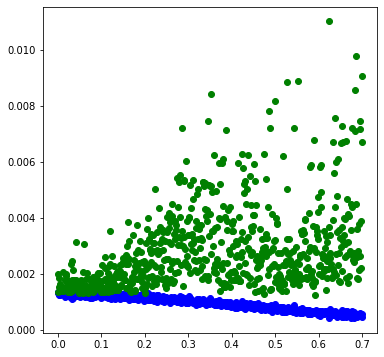

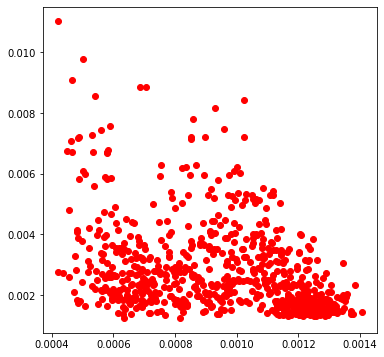

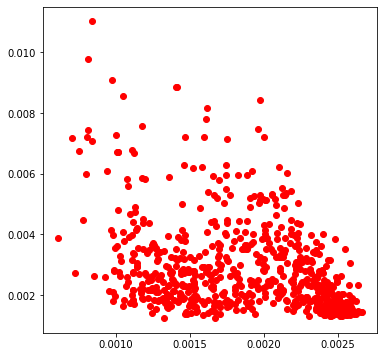

In [216]:
gaml=np.linspace(0,gammax,len(L))
plt.figure(figsize=(6, 6))
# plt.plot(gaml,(pssb),'ro')
plt.plot(gaml,pss,'bo')
plt.plot(gaml,L,'go')

plt.figure(figsize=(6, 6))
plt.plot(pss,L,'ro')
plt.figure(figsize=(6, 6))
plt.plot(pssb,L,'ro')
# plt.plot(gaml,1/gaml)

In [218]:
import pickle

f = open('LPss1.pckl', 'wb')
pickle.dump([L,pss,pssb], f)
f.close()


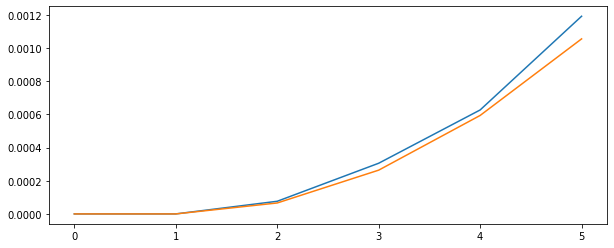

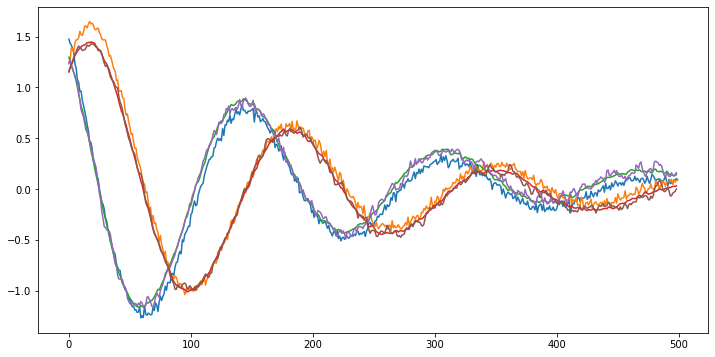

In [213]:

perf,perfb=0,0
for sigma in np.arange(0,.1,1/50):
    yp=Prediction(x,0,res,seq_len)
    yn=Prediction(x,sigma,res,seq_len)
    perf=np.append(perf,((yp-yn)*(yp-yn)).mean(axis=None))
    perfb=np.append(perfb,Perf_bound(RNN)*sigma**2)

plt.figure(figsize=(10, 4))
plt.plot(perf)
plt.plot(perfb)
A,B,C,b,c=rnn.Weights()
# mng = plt.get_current_fig_manager()
# mng.frame.Maximize(True)
plt.figure(figsize=(12, 6))

yp=Prediction(x,0,res,seq_len)
yn=Prediction(x,sigma,res,seq_len)
plt.plot(x[seq_len:])
plt.plot(yp)
plt.plot(yn)

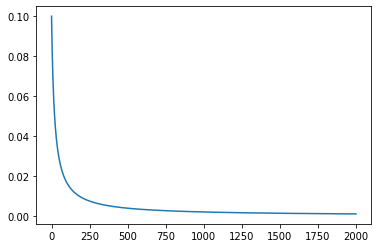

In [139]:
T=np.linspace(0,M_epoch,M_epoch)
gam=.1/(T/20+1)
plt.plot(gam)